In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchsummary

# ResNet

In [2]:
EXPANSION = 4

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = EXPANSION
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride
        # print("-"*70)
        # print("Number of parameters: ", sum([p.numel() for p in self.parameters()]))

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [4]:
class ResNetEncoder(nn.Module):
    def __init__(self, block, layers, image_channels, n_latent=128):
        super(ResNetEncoder, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.expansion = EXPANSION

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
        block, layers[0], intermediate_channels=32, stride=1
        )
        self.layer2 = self._make_layer(
        block, layers[1], intermediate_channels=64, stride=2
        )
        # self.layer3 = self._make_layer(
        # block, layers[2], intermediate_channels=64, stride=2
        # )
        # self.layer4 = self._make_layer(
        # block, layers[3], intermediate_channels=128, stride=2
        # )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.expansion * 64, n_latent)
        print("-"*70)
        # print("Number of parameters: ", sum([p.numel() for p in self.layer1.parameters()])/1000, "k")
        # print("Number of parameters: ", sum([p.numel() for p in self.layer2.parameters()])/1000, "k")
        # print("Number of parameters: ", sum([p.numel() for p in self.layer3.parameters()])/1000, "k")
        # # print("Number of parameters: ", sum([p.numel() for p in self.layer4.parameters()])/1000, "k")
        
        print("Number of parameters: ", sum([p.numel() for p in self.parameters()])/1e6, "M")
        print("-"*70)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)
        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead


        if stride != 1 or self.in_channels != intermediate_channels * self.expansion:
            identity_downsample = nn.Sequential(
            nn.Conv2d(
            self.in_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=stride,
            bias=False
            ),
            nn.BatchNorm2d(intermediate_channels * self.expansion),
            )

            layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
            )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * self.expansion

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for _ in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)



In [5]:
def SmallResNet(img_channel=3, n_latent=128):
    return ResNetEncoder(block, [3, 4, 6, 3], img_channel, n_latent=n_latent)

In [6]:
# model = SmallResNet(img_channel=3).cuda()
# # torchsummary.summary(model, input_size=(3, 228, 228))
# print(torchsummary.summary(model, (3, 28, 28)))

In [7]:
class Decoder(nn.Module):
	def __init__(self, img_channel=3, n_latent=128):
		super(Decoder,self).__init__()
		self.img_channel = img_channel
		self.n_latent = n_latent
		self.conv_shape = (256, 1, 1)
		prods = self.conv_shape[0] * self.conv_shape[1] * self.conv_shape[2]
		self.dfc2 = nn.Linear(n_latent, prods)
		self.bn2 = nn.BatchNorm1d(prods)
		self.dfc1 = nn.Linear(prods, prods)
		self.bn1 = nn.BatchNorm1d(prods)
		self.upsample1=nn.Upsample(scale_factor=2)
		self.dconv5 = nn.ConvTranspose2d(self.conv_shape[0], 128, 3, padding = 0)
		self.dconv4 = nn.ConvTranspose2d(128, 64, 3, padding = 1)
		self.dconv3 = nn.ConvTranspose2d(64, 32, 3, padding = 1)
		self.dconv2 = nn.ConvTranspose2d(32, 16, 4, padding = 2)
		self.dconv1 = nn.ConvTranspose2d(16, img_channel, 6, stride = 2, padding = 2)

		print("Number of parameters in decoder: ", sum([p.numel() for p in self.parameters()])/1e6, "M")
		# for p in self.parameters():
		# 	print(p.numel())

	def forward(self,x):#,i1,i2,i3):
		batch_size = x.size(0)
		# print(x.size())
		x = self.dfc2(x)
		x = F.relu(self.bn2(x))
		# print(x.size())
		#x = F.relu(x)
		x = self.dfc1(x)
		x = F.relu(self.bn1(x))
		# print(x.size())
		#x = F.relu(x)
		# print(x.size())

		x = x.view(batch_size,self.conv_shape[0],self.conv_shape[1],self.conv_shape[2])
		# print (x.size())
		x=self.upsample1(x)
		# print(x.size())
		x = self.dconv5(x)
		# print(x.size())
		x = F.relu(x)
		# print(x.size())
		x = F.relu(self.dconv4(x))
		# print(x.size())
		x = F.relu(self.dconv3(x))
		# print(x.size())
		x=self.upsample1(x)
		# print(x.size())
		x = self.dconv2(x)
		# print(x.size())
		x = F.relu(x)
		x=self.upsample1(x)
		# print(x.size())
		x = self.dconv1(x)
		# print(x.size())
		x = torch.sigmoid(x)
		#print x
		return x

In [8]:
# model_dec = Decoder(n_latent=128).cuda()
# model_dec(torch.randn(3,128).cuda()).shape
# # print(torchsummary.summary(model_dec, (128)))

In [9]:
class ResNetAE(nn.Module):
    def __init__(self, img_channel=3, n_latent=128):
        super(ResNetAE, self).__init__()
        self.encoder = SmallResNet(img_channel=img_channel, n_latent=n_latent)
        self.decoder = Decoder(img_channel, n_latent)
        print("-"*50)
        print("Number of parameters in AE: ", sum([p.numel() for p in self.parameters()])/1e6, "M")

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
ae = ResNetAE(img_channel=3, n_latent=128).to(device)

pathResNetAE = "ssh/ae_custom_resnet_moving_mnist_latent_128_n_channels_3_last_model.pt"
ae.load_state_dict(torch.load(pathResNetAE))


----------------------------------------------------------------------
Number of parameters:  0.408896 M
----------------------------------------------------------------------
Number of parameters in decoder:  0.497075 M
--------------------------------------------------
Number of parameters in AE:  0.905971 M


<All keys matched successfully>

# Deep CNNs

In [91]:

class Encoder(nn.Module):
    def __init__(self, device, latent_dim, in_channels,
                    activation=nn.ReLU(), relu=False):
        super(Encoder, self).__init__()
        self.device = device
        self.latent_dim = latent_dim
        # self.appearance_dim = appearance_dim
        self.in_channels = in_channels
        self.activation = activation
        self.relu = relu

        self.encoder = nn.Sequential(
            # first block
                    nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(64),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(kernel_size=2, stride=2),

            # second block
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(128),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(128),
                    nn.MaxPool2d(kernel_size=2, stride=2),

            # third block
                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(256),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(256),
                    nn.MaxPool2d(kernel_size=2, stride=2),

        ).to(device)
        
                    # nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=7, stride=2, padding=1),
                    # self.activation,
                    # # nn.MaxPool2d(kernel_size=2, stride=2),
                    # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=1),
                    # self.activation,
                    # # nn.MaxPool2d(kernel_size=2, stride=2),
                    # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
                    # self.activation,
                    # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
                    # self.activation,
                    # nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=0),
                    # self.activation
                    # # nn.MaxPool2d(kernel_size=2, stride=2),
        self.encoder_dynamics = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=256*4*4, out_features=self.latent_dim),
        ).to(device)

        # self.encoder_appearance = nn.Sequential(
        #             nn.Flatten(),
        #             nn.Linear(in_features=2*2*512, out_features=self.appearance_dim),
        # ).to(device)
        
        # print the number of parameters in the model
        print("Number of parameters in the encoder model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))


    def forward(self, image):
        # print(image.shape)
        out = self.encoder(image)
        # print(out.shape)
        dyn = self.encoder_dynamics(out)
        stacked_tensor = dyn
        # appearance = self.encoder_appearance(out)

        # # In order to apply the class TimeDistributed
        # # dyn: N x D, appearance: N x A
        # stacked_tensor = torch.cat((dyn, appearance), dim=-1)

        return stacked_tensor

class Decoder(nn.Module):
    def __init__(self, device, latent_dim, in_channels,
                    activation=nn.ReLU()):
        super(Decoder, self).__init__()
        self.device = device
        # self.dynamics_dim = dynamics_dim
        # self.appearance_dim = appearance_dim
        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.activation = activation

        self.decoder_linear = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=256*4*4),
                    self.activation
        ).to(device)

        self.decoder = nn.Sequential(
            # first block
                    nn.Upsample(scale_factor=2, mode='bilinear'),
                    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(128),
                    nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(128),

            # second block
                    nn.Upsample(scale_factor=2, mode='bilinear'),
                    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(64),
                    nn.ConvTranspose2d(64, 64, kernel_size=4, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(64),
            
            # third block
                    nn.Upsample(scale_factor=2, mode='bilinear'),
                    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(32),
                    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=1, padding=0),
                    self.activation,
                #     nn.BatchNorm2d(32),

                #     nn.Conv2d(in_channels=32, out_channels=self.in_channels, kernel_size=1, stride=1, padding=1),
                    nn.Sigmoid()
                    

                    
        ).to(device)

                    # nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=0),
                    # self.activation,
                    # nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1),
                    # self.activation,
                    # nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
                    # self.activation,
                    # nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=1),
                    # self.activation,
                    # nn.ConvTranspose2d(in_channels=32, out_channels=self.in_channels, kernel_size=7, stride=2, padding=0),
                    # nn.Sigmoid()

        # print the number of parameters in the model
        print("Number of parameters in the decoder model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))

    def forward(self, latent):

        out = self.decoder_linear(latent)
        # print(out.shape)
        out = out.view(latent.shape[0], 256, 4, 4)
        # print(out.shape)
        out = self.decoder(out)
        # print(out.shape)
        return out

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = torch.randn(32, 3, 64, 64).to(device)
# print(inputs)
encoder = Encoder(device, latent_dim=128, in_channels=3)
# print(encoder.encoder)
# encoder
print(encoder(inputs).shape)
del encoder

Number of parameters in the encoder model: 1671616
torch.Size([32, 128])


In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = torch.randn(32, 128).to(device)
# print(inputs)
decoder = Decoder(device, latent_dim=128, in_channels=3)
# print(encoder.encoder)
# encoder
print(decoder(inputs).shape)
torchsummary.summary(decoder, (128,))
del decoder

Number of parameters in the decoder model: 1131875
torch.Size([32, 3, 64, 64])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         528,384
              ReLU-2                 [-1, 4096]               0
              ReLU-3                 [-1, 4096]               0
              ReLU-4                 [-1, 4096]               0
          Upsample-5            [-1, 256, 8, 8]               0
   ConvTranspose2d-6          [-1, 128, 10, 10]         295,040
              ReLU-7          [-1, 128, 10, 10]               0
              ReLU-8          [-1, 128, 10, 10]               0
              ReLU-9          [-1, 128, 10, 10]               0
      BatchNorm2d-10          [-1, 128, 10, 10]             256
  ConvTranspose2d-11          [-1, 128, 12, 12]         147,584
             ReLU-12          [-1, 128, 12, 12]               0
             ReLU-13    

In [94]:
class AE_DeepCNN(nn.Module):
    def __init__(self, device, latent_dim, in_channels,
                    activation=nn.ReLU(), relu=False):
        super(AE_DeepCNN, self).__init__()
        
        self.device = device
        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.activation = activation
        self.relu = relu

        self.encoder = Encoder(device, latent_dim=self.latent_dim, in_channels=self.in_channels, activation=self.activation, relu=self.relu)
        self.decoder = Decoder(device, latent_dim=self.latent_dim, in_channels=self.in_channels, activation=self.activation)

    def forward(self, image):
        latent = self.encoder(image)
        out = self.decoder(latent)
        return out

ae = AE_DeepCNN(device, latent_dim=128, in_channels=3)

Number of parameters in the encoder model: 1671616
Number of parameters in the decoder model: 1131875


In [95]:
ae(torch.randn(32, 3, 64, 64).to(device)).shape

torch.Size([32, 3, 64, 64])

# Gravity Hole dataset

In [41]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import trange
from sklearn.model_selection import train_test_split

from src.data.generate import generate_gravity_hole_ball_images
from src.data.box import GravityHoleBall
from src.utils.utils import add_spatial_encoding

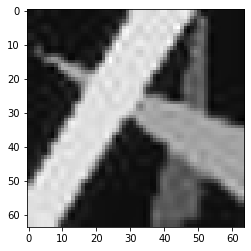

--------------------------------------------------
Generating images...


100%|██████████| 500/500 [00:29<00:00, 16.88it/s]


(50500, 1, 64, 64)
torch.Size([50500, 3, 64, 64])


100%|██████████| 50/50 [00:01<00:00, 34.15it/s]


(2500, 1, 64, 64)
torch.Size([2500, 3, 64, 64])


In [64]:
MARGIN_MIN = 5
MIN_INIT_VELOCITY = 200.
WIDTH, HEIGHT = 64, 64
RADIUS = 3

# import a jpeg image 
background_image = Image.open('images/AE_ODE/Gravity/black_wallpaper.jpeg')
background_image = np.array(background_image)
background_image = background_image/255.
# transform to gray image
background_image = np.mean(background_image, axis=2)
# resize to 28x28
background_image = np.array(Image.fromarray(background_image).resize((WIDTH, HEIGHT)))
plt.imshow(background_image, cmap='gray')
plt.show()
background_image.max(), background_image.min()

infos = {
    "MARGIN_MIN":MARGIN_MIN,
    "MIN_INIT_VELOCITY":MIN_INIT_VELOCITY,
    "WIDTH":WIDTH,
    "HEIGHT":HEIGHT,
    "RADIUS":RADIUS
}

x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)


Num_pos_velocity = 1
N = 500
N_frames = 100 + Num_pos_velocity
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)
print("-"*50)
print("Generating images...")
def generate_input(box=box, N=N, N_frames=N_frames, dt=dt):
    images = generate_gravity_hole_ball_images(box, N=N, N_frames=N_frames, dt=dt, infos=infos, background_image=background_image).reshape(-1, 1, HEIGHT, WIDTH)
    print(images.shape)
    # dataset = [(image, 0) for image in dataset]
    # dataset = add_spatial_encoding(dataset)
    # print(len(dataset), len(dataset[0]), dataset[0][0].shape)
    images = torch.from_numpy(add_spatial_encoding(images)).float()
    print(images.shape)
    return images

images = generate_input()
images_test = generate_input(N=50, N_frames=50)


In [65]:
dataset = TensorDataset(images)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(images_test)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Moving MNIST dataset

In [96]:
HEIGHT, WIDTH = 64, 64
print("-"*50)
print("Generating images...")
images = np.load("data/mnist_test_seq.npy").swapaxes(0,1)
images = (images - images.min())/(images.max() - images.min())
print(images.shape)
shape = images.shape

images = images.reshape(-1, 1, shape[-2], shape[-1])[:200000//3]
print(images.shape)
N = shape[0]
N_frames = shape[1]
dt = 1./N_frames
Num_pos_velocity = 1
times = np.arange(0, N_frames*dt, dt)

# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images, images_test = train_test_split(images, test_size=0.1, random_state=42)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(-1, 3, HEIGHT, WIDTH)
images_test = torch.from_numpy(add_spatial_encoding(images_test)).float().reshape(-1, 3, HEIGHT, WIDTH)
print(images.shape, images_test.shape)

--------------------------------------------------
Generating images...
(10000, 20, 64, 64)
(66666, 1, 64, 64)
torch.Size([59999, 3, 64, 64]) torch.Size([6667, 3, 64, 64])


In [97]:
dataset = TensorDataset(images)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(images_test)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Training

In [83]:
def reconstruction(model, plot_loader):
        model.eval()
        for i, [input_image] in enumerate(plot_loader):
            input_image = input_image.float().to(device)
            batch_size = input_image.shape[0]
            img = model(input_image)
            img = img[:,0].cpu().detach().numpy()
            img = np.reshape(img, (batch_size, HEIGHT, WIDTH))
            input_image = input_image[:,0].cpu().detach().numpy()
            input_image = np.reshape(input_image, (batch_size, HEIGHT, WIDTH))

            fig, ax = plt.subplots(figsize=(2*batch_size,4))
            for i in range(batch_size):
                plt.subplot(2, batch_size, i+1)
                plt.imshow(img[i], cmap='gray')
                plt.axis('off')
                
            for i in range(batch_size):
                plt.subplot(2, batch_size, i+1+batch_size)
                plt.imshow(input_image[i], cmap='gray')
                plt.axis('off')
            plt.show()
            break

def train(model, dataloader_train, dataloader_test, optimizer, scheduler, criterion, epochs=10, display_step=1, n_plot=10):
        iterator = trange(epochs)
        losses_train = []
        losses_test = []
        for _ in iterator:
            reconstruction(model, dataloader_test)
            
            loss_epoch = 0
            model.train()
            for i, [input_image] in enumerate(dataloader_train):
                input_image = input_image.float().to(device)
                optimizer.zero_grad()
                img = model(input_image)
                loss = criterion(input_image, img)
                loss.backward()
                optimizer.step()
                loss_epoch += loss.item()
                if i % display_step == 0:
                    iterator.set_description(f'Batch: {i}/{len(dataloader_train)}, Loss: {loss_epoch/(i+1):.6f}')
                

            # losses_train.append(loss_epoch/len(dataloader_train))
            model.eval()
            with torch.no_grad():
                loss_epoch = 0
                for i, [input_image] in enumerate(dataloader_test):
                    input_image = input_image.float().to(device)
                    img = model(input_image)
                    loss = criterion(input_image, img)
                    loss_epoch += loss.item()
                    if i % display_step == 0:
                        iterator.set_postfix_str(f'Test Batch: {i}/{len(dataloader_test)}, Loss: {loss_epoch/(i+1):.6f}')

                # losses_test.append(loss_epoch/len(dataloader_test))
            
            scheduler.step()

In [98]:
# ae = ResNetAE(img_channel=3, n_latent=128).to(device)
ae = AE_DeepCNN(device, in_channels=3, latent_dim=128).to(device)

Number of parameters in the encoder model: 1671616
Number of parameters in the decoder model: 1131875


In [99]:
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.MSELoss()

  0%|          | 0/100 [00:00<?, ?it/s]

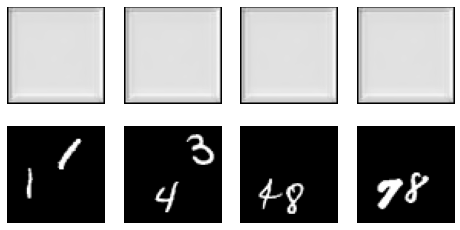

Batch: 937/938, Loss: 0.017234:   1%|          | 1/100 [01:08<1:53:05, 68.54s/it, Test Batch: 1666/1667, Loss: 0.012978]

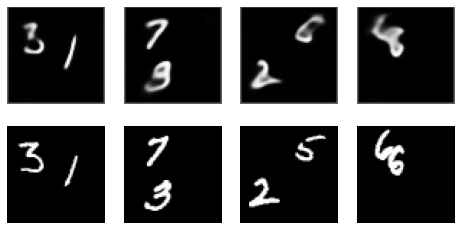

Batch: 937/938, Loss: 0.011534:   2%|▏         | 2/100 [02:19<1:54:39, 70.20s/it, Test Batch: 1666/1667, Loss: 0.010619]

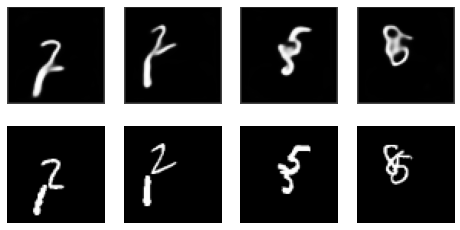

Batch: 937/938, Loss: 0.009892:   3%|▎         | 3/100 [03:31<1:54:39, 70.92s/it, Test Batch: 1666/1667, Loss: 0.009411]

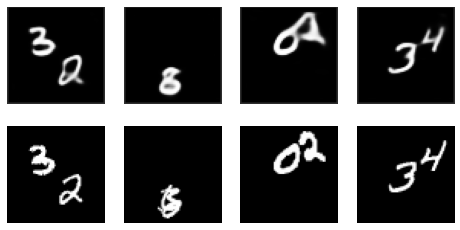

Batch: 937/938, Loss: 0.009115:   4%|▍         | 4/100 [04:43<1:54:03, 71.29s/it, Test Batch: 1666/1667, Loss: 0.008981]

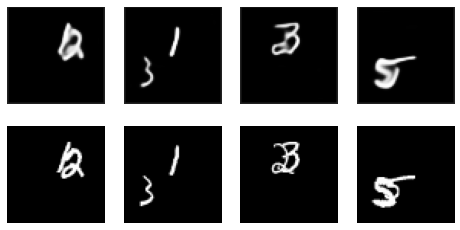

Batch: 937/938, Loss: 0.008683:   5%|▌         | 5/100 [05:55<1:53:08, 71.46s/it, Test Batch: 1666/1667, Loss: 0.008601]

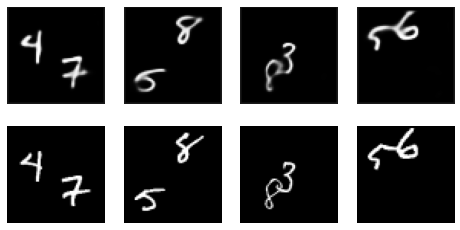

Batch: 937/938, Loss: 0.008419:   6%|▌         | 6/100 [07:06<1:51:57, 71.46s/it, Test Batch: 1666/1667, Loss: 0.008342]

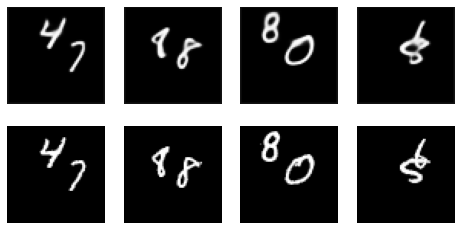

Batch: 937/938, Loss: 0.008235:   7%|▋         | 7/100 [08:18<1:50:39, 71.40s/it, Test Batch: 1666/1667, Loss: 0.008254]

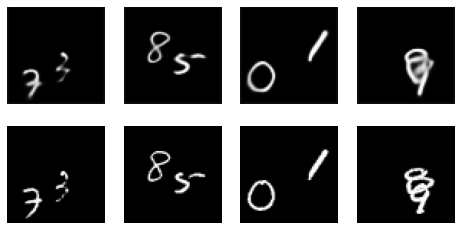

Batch: 937/938, Loss: 0.008110:   8%|▊         | 8/100 [09:29<1:49:21, 71.32s/it, Test Batch: 1666/1667, Loss: 0.008144]

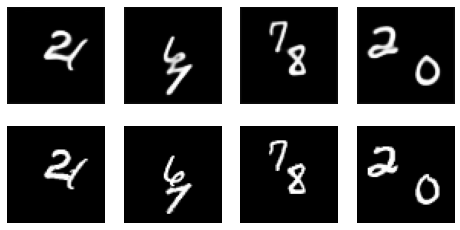

Batch: 937/938, Loss: 0.008012:   9%|▉         | 9/100 [10:40<1:48:05, 71.27s/it, Test Batch: 1666/1667, Loss: 0.008136]

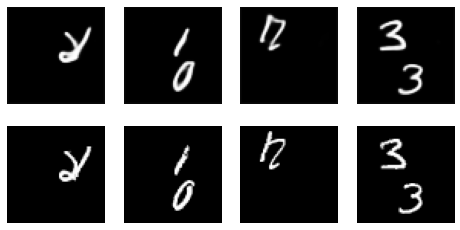

Batch: 937/938, Loss: 0.007938:  10%|█         | 10/100 [11:51<1:46:49, 71.21s/it, Test Batch: 1666/1667, Loss: 0.008007]

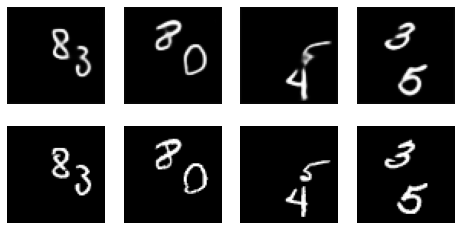

Batch: 937/938, Loss: 0.007731:  11%|█         | 11/100 [13:02<1:45:38, 71.21s/it, Test Batch: 1666/1667, Loss: 0.007835]

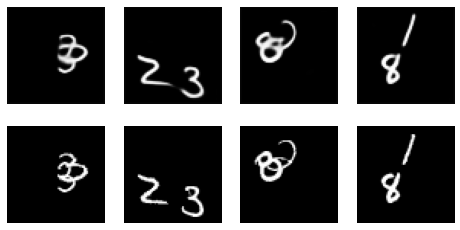

Batch: 937/938, Loss: 0.007692:  12%|█▏        | 12/100 [14:13<1:44:23, 71.18s/it, Test Batch: 1666/1667, Loss: 0.007786]

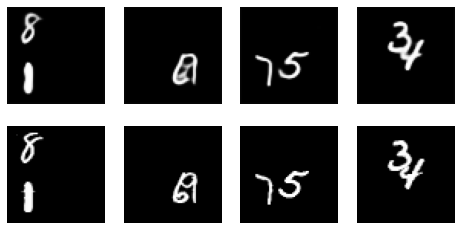

Batch: 145/938, Loss: 0.007650:  12%|█▏        | 12/100 [14:24<1:45:37, 72.02s/it, Test Batch: 1666/1667, Loss: 0.007786]


KeyboardInterrupt: 

In [100]:
train(ae, train_loader, test_loader, optimizer, scheduler, criterion, epochs=100, display_step=1, n_plot=10)

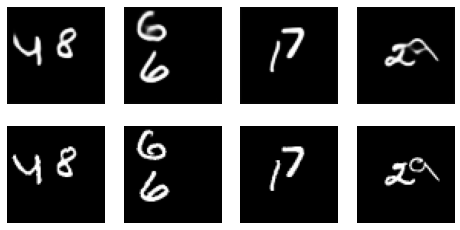

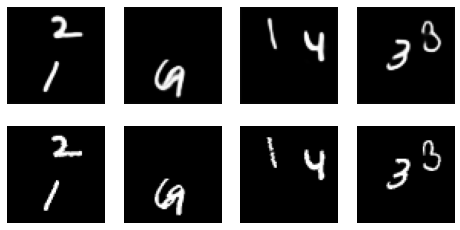

In [104]:
reconstruction(ae, test_loader)
train_loader_plot = DataLoader(dataset, batch_size=4, shuffle=True)
reconstruction(ae, train_loader_plot)

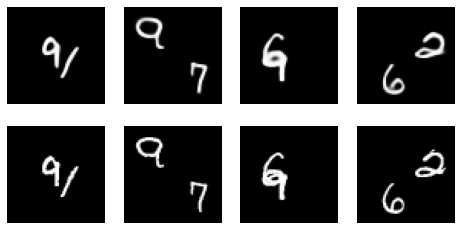

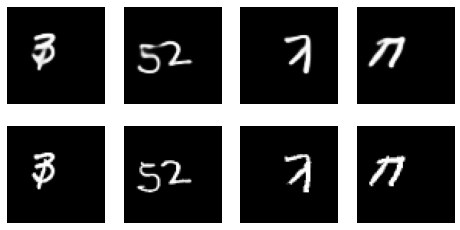

In [90]:
reconstruction(ae, test_loader)
train_loader_plot = DataLoader(dataset, batch_size=4, shuffle=True)
reconstruction(ae, train_loader_plot)

In [37]:
pathAE = "ssh/ae_custom_resnet_moving_mnist_latent_{}_n_channels_{}_last_model.pt".format(128, 3)

torch.save(ae.state_dict(), pathAE)